In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Adjust display settings
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Expand the width to show all columns
pd.set_option('display.max_rows', None)     # Show all rows (if needed)

In [3]:
# Load Data
df = pd.read_csv('train_key_features 2.csv')

In [4]:
df.shape

(20631, 11)

In [5]:
df = df[df['RUL']!=0]

In [6]:
df.shape

(20531, 11)

In [7]:
X = df.drop(columns=['RUL'],axis=1)

In [8]:
X.head()

,time_in_cycles,T50,P30,Ps30,Nc,NRf,phi,BPR,W32,htBleed
0,1,1400.60,554.36,47.47,9046.19,2388.02,521.66,8.4195,23.4190,392
1,2,1403.14,553.75,47.49,9044.07,2388.07,522.28,8.4318,23.4236,392
2,3,1404.20,554.26,47.27,9052.94,2388.03,522.42,8.4178,23.3442,390
3,4,1401.87,554.45,47.13,9049.48,2388.08,522.86,8.3682,23.3739,392
4,5,1406.22,554.00,47.28,9055.15,2388.04,522.19,8.4294,23.4044,393


In [10]:
y = df['RUL']

In [11]:
# Apply log transformation to the target
# Log transformation function
def log_transform(x):
    return np.log1p(x)
y_log = log_transform(y)

In [12]:
# Standardize the log-transformed target
y_scaler = RobustScaler()
y_scaled= y_scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()

In [13]:
# Define the log transformation pipeline
log_transformer = Pipeline(steps=[
    ('log', FunctionTransformer(log_transform)),
    ('scaler', RobustScaler())
])

# Define the standard scaling pipeline
standard_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95))  # Retain 95% of variance
])

# Define the robust scaling pipeline
robust_transformer = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=0.95))  # Retain 95% of variance
])

# Create a column transformer with specific transformations
preprocessor = ColumnTransformer(
    transformers=[
        ("log", log_transformer, ['time_in_cycles', 'Nc']),
        ("standard", standard_transformer, ['T50', 'P30', 'Ps30', 'phi', 'BPR', 'W32']),
        ("robust", robust_transformer, ['NRf', 'htBleed'])
    ]
)

In [14]:
X_scaled = preprocessor.fit_transform(X)

In [15]:
X_scaled.shape

(20531, 9)

In [16]:
y_scaled.shape

(20531,)

In [17]:
# Split data into training and validation sets
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(X_scaled,y_scaled
                                                  ,test_size=0.2,random_state=42)


In [18]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [19]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_val_mae , model_val_rmse, model_val_r2 = evaluate_model(y_val, y_val_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_val_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_val_mae))
    print("- R2 Score: {:.4f}".format(model_val_r2))
    r2_list.append(model_val_r2)
    
    print('='*35)
    print('\n')


Linear Regression
Model performance for Training set
- Root Mean Squared Error: 0.3989
- Mean Absolute Error: 0.3096
- R2 Score: 0.7853
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4069
- Mean Absolute Error: 0.3173
- R2 Score: 0.7680


Lasso
Model performance for Training set
- Root Mean Squared Error: 0.7724
- Mean Absolute Error: 0.5900
- R2 Score: 0.1949
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.7589
- Mean Absolute Error: 0.5746
- R2 Score: 0.1932


Ridge
Model performance for Training set
- Root Mean Squared Error: 0.3989
- Mean Absolute Error: 0.3096
- R2 Score: 0.7853
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.4069
- Mean Absolute Error: 0.3173
- R2 Score: 0.7680


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 0.2671
- Mean Absolute Error: 0.2054
- R2 Score: 0.9037
-----------------------

In [20]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
7,CatBoosting Regressor,0.875788
5,Random Forest Regressor,0.873127
6,XGBRegressor,0.866646
8,AdaBoost Regressor,0.854040
3,K-Neighbors Regressor,0.852334
2,Ridge,0.767995
0,Linear Regression,0.767994
4,Decision Tree,0.744626
1,Lasso,0.193196


In [21]:
# Initialize few parametrs for Hyperparamter tunning
rf_params={"max_depth":[5,8,15,None,10],
           "max_features":[5,7,"auto",8],
           "min_samples_split":[2,8,15,20],
           "n_estimators":[100,200,500,1000]}

cb_params = {
    "iterations": [100, 200, 500, 1000],
    "depth": [4, 6, 8, 10],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "l2_leaf_reg": [1, 3, 5, 7, 9]
}

In [22]:
# Model List for Hyperparameter Tunning
randomcv_models=[("RF",RandomForestRegressor(),rf_params), 
                 ("CatBoost", CatBoostRegressor(verbose=0), cb_params)
                 ]

In [23]:
##Hyperparameter Tuning
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END max_depth=None, max_features=auto, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=8, max_features=auto, min_samples_split=8, n_estimators=200; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=None, max_features=auto, min_samples_split=15, n_estimators=500; total time=   0.0s
[CV] END max_depth=8, max_features=auto, min_samples_split=8, n_estimators=200; total time=   0.0s
[CV] END max_depth=8, max_features=auto, min_samples_split=8, n_estimators=200; total time=   0.0s
[CV] END max_depth=8, max_features=5, min_samples_split=8, n_estimators=100; total time=   2.6s
[CV] END max_depth=8, max_features=5, min_samples_split=8, n_estimators=100; total time=   2.6s
[CV] END max_depth=8, max_features=5, min_samples_split=8, n_estimators=100; total time=   2.8s
[CV] END max_depth=5, max_features=8, min_s

In [25]:
## Retraining the models with best parameters
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=500, min_samples_split=8, max_features=5, max_depth=15, 
                                                     n_jobs=-1),
    "CatBoost Regressor": CatBoostRegressor(learning_rate=0.05, l2_leaf_reg=9,iterations=500,depth=6)  
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_val)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_val, y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Val set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

Random Forest Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1890
- Mean Absolute Error: 0.1457
- R2 Score: 0.9518
----------------------------------
Model performance for Val set
- Root Mean Squared Error: 0.2974
- Mean Absolute Error: 0.2289
- R2 Score: 0.8760


0:	learn: 0.8268085	total: 2.79ms	remaining: 1.39s
1:	learn: 0.7959746	total: 4.23ms	remaining: 1.05s
2:	learn: 0.7655938	total: 5.58ms	remaining: 925ms
3:	learn: 0.7365967	total: 6.91ms	remaining: 857ms
4:	learn: 0.7092076	total: 8.26ms	remaining: 818ms
5:	learn: 0.6835857	total: 9.62ms	remaining: 792ms
6:	learn: 0.6602978	total: 11.3ms	remaining: 792ms
7:	learn: 0.6384987	total: 13ms	remaining: 798ms
8:	learn: 0.6179804	total: 14.8ms	remaining: 805ms
9:	learn: 0.5975453	total: 16.1ms	remaining: 791ms
10:	learn: 0.5788787	total: 18.3ms	remaining: 811ms
11:	learn: 0.5605553	total: 19.7ms	remaining: 801ms
12:	learn: 0.5436723	total: 21ms	remaining: 788ms
13:	learn: 0.5278822	total: 22.7ms	remaining: 

In [26]:

# Initialize the Random Forest Regressor
cat_model = CatBoostRegressor(learning_rate=0.05, l2_leaf_reg=9,iterations=500,depth=6)

# Fit the model to the training data
cat_model = cat_model.fit(X_train, y_train)

# Predict using the test data
y_pred = cat_model.predict(X_val)

# Calculate the R^2 score
score = r2_score(y_val, y_pred) * 100

# Print the accuracy of the model
print("Accuracy of the model is %.2f" % score)


0:	learn: 0.8268085	total: 2.79ms	remaining: 1.39s
1:	learn: 0.7959746	total: 5.18ms	remaining: 1.29s
2:	learn: 0.7655938	total: 7.08ms	remaining: 1.17s
3:	learn: 0.7365967	total: 8.79ms	remaining: 1.09s
4:	learn: 0.7092076	total: 11.1ms	remaining: 1.1s
5:	learn: 0.6835857	total: 12.7ms	remaining: 1.05s
6:	learn: 0.6602978	total: 14.4ms	remaining: 1.01s
7:	learn: 0.6384987	total: 15.9ms	remaining: 978ms
8:	learn: 0.6179804	total: 17.5ms	remaining: 952ms
9:	learn: 0.5975453	total: 19.2ms	remaining: 941ms
10:	learn: 0.5788787	total: 21ms	remaining: 932ms
11:	learn: 0.5605553	total: 22.8ms	remaining: 929ms
12:	learn: 0.5436723	total: 24.6ms	remaining: 921ms
13:	learn: 0.5278822	total: 26.4ms	remaining: 915ms
14:	learn: 0.5128311	total: 28.5ms	remaining: 922ms
15:	learn: 0.4987122	total: 30ms	remaining: 908ms
16:	learn: 0.4858030	total: 31.7ms	remaining: 899ms
17:	learn: 0.4736217	total: 33.5ms	remaining: 896ms
18:	learn: 0.4621630	total: 35ms	remaining: 887ms
19:	learn: 0.4514910	total: 3

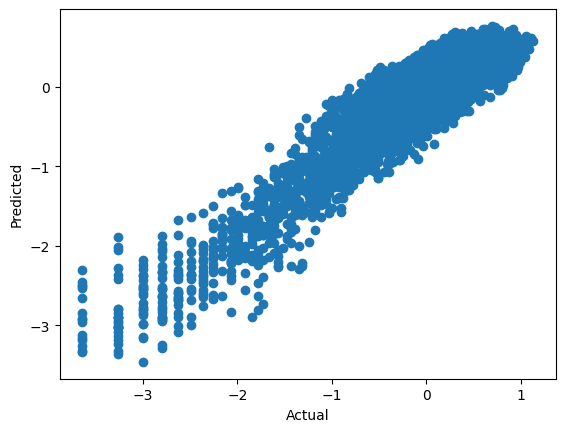

In [27]:
import matplotlib.pyplot as plt
plt.scatter(y_val,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

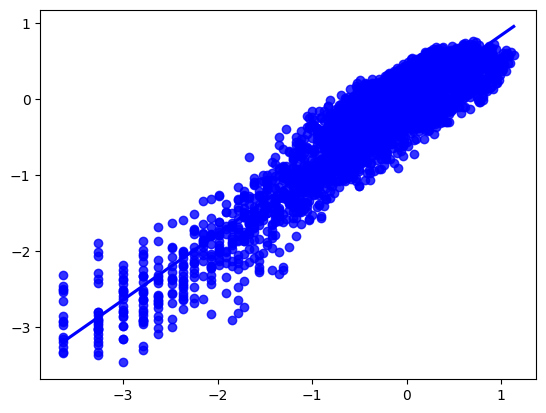

In [34]:
import seaborn as sns
sns.regplot(x=y_val,y=y_pred,ci=None,color ='blue')
plt.show()

In [29]:
pred_df=pd.DataFrame({'Actual Value':y_val,'Predicted Value':y_pred,'Difference':y_val-y_pred})
pred_df.head(20)

,Actual Value,Predicted Value,Difference
0,-1.241815,-1.360641,0.118826
1,-0.391253,-0.975125,0.583872
2,0.379256,0.461123,-0.081867
3,-0.711991,-0.351325,-0.360667
4,0.785279,0.403629,0.381650
5,0.367450,0.549915,-0.182465
6,-0.951673,-0.401392,-0.550281
7,0.260474,0.104232,0.156242
8,0.161969,-0.299463,0.461431
9,0.131774,0.063900,0.067874


In [30]:
import numpy as np

def inverse_log_transform(y_log):
    return np.exp(y_log)


In [31]:
# Inverse transform the predictions
y_pred_log = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_pred_inv = inverse_log_transform(y_pred_log)

y_val_log = y_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
y_val_inv = inverse_log_transform(y_val_log)


In [32]:
pred_df=pd.DataFrame({'Actual Value':y_val_inv,'Predicted Value':y_pred_inv,'Difference':y_val_inv-y_pred_inv})
pred_df.head(20)

,Actual Value,Predicted Value,Difference
0,27.0,23.731358,3.268642
1,68.0,36.069575,31.930425
2,157.0,171.597115,-14.597115
3,48.0,71.013401,-23.013401
4,244.0,161.210903,82.789097
5,155.0,188.967144,-33.967144
6,37.0,67.255410,-30.255410
7,138.0,116.463938,21.536062
8,124.0,75.127623,48.872377
9,120.0,111.473121,8.526879
